In [3]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import skrf as rf
rf.stylely()
skrf_color_names = ['blue','red','green','orange','purple','pink','grey']
skrf_colors = dict(zip(skrf_color_names, rf.plotting.colors()))
import math

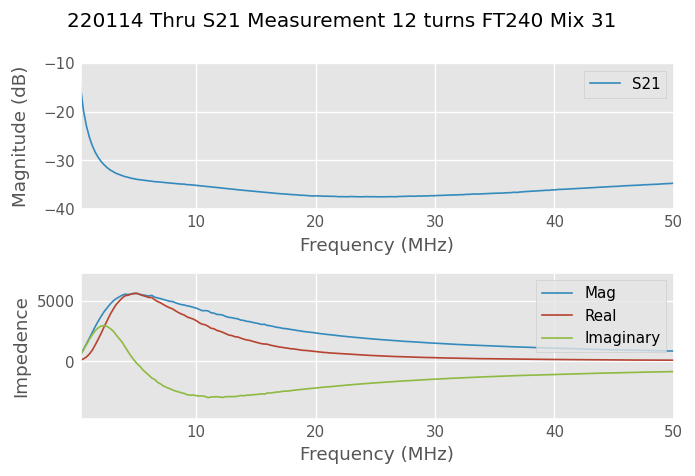

In [4]:
# Load the RF Choke measurement
rf_choke = rf.Network('220114 Thru S21 Measurement 12 turns FT240 Mix 31.s2p')
#rf_choke = rf.Network('220224_8753C_6T_BLN43-202_SMA_Cal_run3.s2p')

fig, axes = plt.subplots(nrows=2, ncols=1)

# Plot the measured common mode attenuation
rf_choke.s21.plot_s_db(ax=axes[0], label="S21")
axes[0].set_ylim([-40, -10])

# Plot the impedence seen by port 1
rf_choke.s11.plot_z_mag(ax=axes[1], label="Mag")
rf_choke.s11.plot_z_re(ax=axes[1], label="Real")
rf_choke.s11.plot_z_im(ax=axes[1], label="Imaginary")
axes[1].set_ylabel("Impedence")
axes[1].legend(loc="upper right")

fig.suptitle(rf_choke.name)
fig.tight_layout()
fig.align_ylabels()

In [5]:
# Input impedence of the choke
z_dut_s11 = rf_choke.s11.z[:,0,0]

# G3TXQ S21 Method
z_dut_s21 = 50 * (2/rf_choke.s[:,1,0] - 2)

# W1QG Y21 Method
z_dut_y21 = 1/-rf_choke.y[:,1,0]

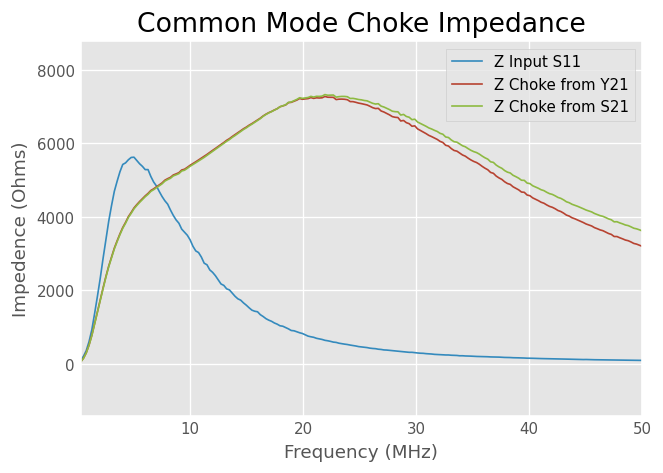

In [6]:
# Plot Zdut from S11, S21, and Y21
fig, axes = plt.subplots()
axes.plot(rf_choke.f/1e6, np.real(z_dut_s11), label="Z Input S11")
axes.plot(rf_choke.f/1e6, np.real(z_dut_y21), label="Z Choke from Y21")
axes.plot(rf_choke.f/1e6, np.real(z_dut_s21), label="Z Choke from S21")
axes.set(xlabel='Frequency (MHz)',
         ylabel='Impedence (Ohms)',
         title='Common Mode Choke Impedance')
axes.legend()
plt.show()

The impedence of a capacitor is $Z_c = \frac{1}{j 2 \pi f C}$

So $C = \frac{1}{j 2 \pi f Z_c}$

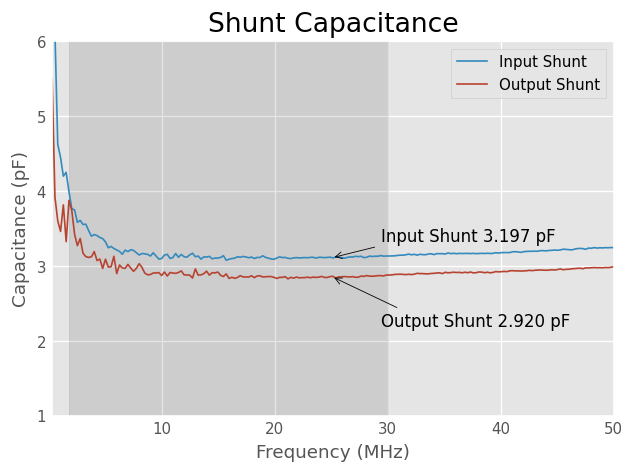

In [7]:
# Shunt Impedences
z_shunt1 = 1/(rf_choke.y[:,0,0] + rf_choke.y[:,1,0])
z_shunt2 = 1/(rf_choke.y[:,1,1] + rf_choke.y[:,0,1])

# Shunt Capacitances
c_shunt1 = np.real(1/(1j*2*math.pi*rf_choke.f*z_shunt1))*1e12
c_shunt2 = np.real(1/(1j*2*math.pi*rf_choke.f*z_shunt2))*1e12

# Calculate the average capacitance over a frequency range
#idx_low  = np.argmax(rf_choke.f > (f_low := 1.8e6))
#idx_high = np.argmax(rf_choke.f > (f_high := 29e6))
#c_shunt1_avg = np.average(c_shunt1[idx_low:idx_high])
#c_shunt2_avg = np.average(c_shunt2[idx_low:idx_high])

# Calculate a representative capacitance
# Average of all values within m sigma of the mean

m = 2
c_shunt1_avg = np.average(c_shunt1[abs(c_shunt1 - np.mean(c_shunt1)) < m * np.std(c_shunt1)])
c_shunt2_avg = np.average(c_shunt2[abs(c_shunt2 - np.mean(c_shunt2)) < m * np.std(c_shunt2)])

fig, ax = plt.subplots()
ax.plot(rf_choke.f/1e6, c_shunt1, label="Input Shunt")
ax.plot(rf_choke.f/1e6, c_shunt2, label="Output Shunt")
#ax.hlines(y=c_shunt1_avg, xmin=1.8, xmax=30, colors=skrf_colors['blue'])
#ax.hlines(y=c_shunt2_avg, xmin=1.8, xmax=30, color=skrf_colors['red'])

# Show the range of values used to calculate the representative capacitance
#ax.axhspan(c_shunt1_avg-m*np.std(c_shunt1), c_shunt1_avg+m*np.std(c_shunt1), 0, 30, alpha=0.2, color='k')
ax.axvspan(1.8, 30, alpha=0.1, color='k')

plt.annotate(f'Input Shunt {c_shunt1_avg:.3f} pF',
             (ax.get_xlim()[1]*0.5, c_shunt1[int(len(c_shunt1)/2)]),
             xytext=(30, 10), textcoords='offset points',
             arrowprops=dict(
                arrowstyle="->",
                color='black',
                connectionstyle="arc,angleA=180,armA=50,rad=10"))
plt.annotate(f'Output Shunt {c_shunt2_avg:.3f} pF',
             (ax.get_xlim()[1]*0.5, c_shunt2[int(len(c_shunt2)/2)]),
             xytext=(30, -30), textcoords='offset points',
             arrowprops=dict(
                arrowstyle="->",
                color='black',
                connectionstyle="arc,angleA=180,armA=50,rad=10"))

ax.set(xlabel='Frequency (MHz)',
       ylabel='Capacitance (pF)',
       title='Shunt Capacitance')
ax.set_ylim([1,6])
ax.legend()
plt.show()

In [8]:
%config InlineBackend.figure_format = 'svg'
import schemdraw
import schemdraw.elements as elm

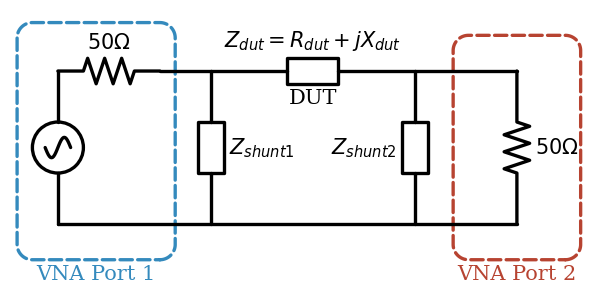

In [10]:
# Shunt Capacitance Model of the Choke
with schemdraw.Drawing(font='serif') as d:
    d += (src   := elm.SourceSin())#.label(('– ','','+'))
    d += (src_r := elm.Resistor()).right().label('$50\Omega$').length(2)
    d += elm.Line().length(1)
    d.push()
    d += elm.ResistorIEC().down().label("$Z_{shunt1}$", loc='bottom')
    d.pop()
    d += elm.ResistorIEC().right().label("$Z_{dut} = R_{dut} +jX_{dut}$", loc="top").label("DUT", loc="bottom").length(4)
    d.push()
    d += (load := elm.ResistorIEC()).down().label("$Z_{shunt2}$")
    d.pop()
    d += elm.Line().right().length(2)
    d += (load := elm.Resistor().down().label("$50\Omega$", loc="bottom"))
    d += elm.Line().left().tox(src.start)
    d += elm.EncircleBox([src, src_r], pady=0.7, padx=0.3).linestyle('--').linewidth(2).color(skrf_colors['blue']).label("VNA Port 1", loc='bottom')
    d += elm.EncircleBox([load], pady=0.7, padx=1).linestyle('--').color(skrf_colors['red']).label('VNA Port 2', loc='bottom')


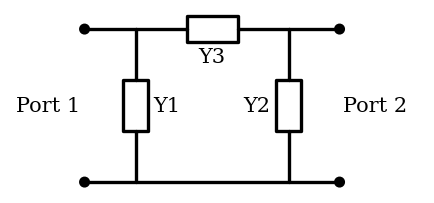

In [11]:
# Two port Pi Network
with schemdraw.Drawing(font='serif', backend='matplotlib') as d:
    d += (port1 := elm.Gap()).up().label('Port 1', loc='top').dot().idot()
    d += elm.Line().right().length(1)
    d.push()
    d += elm.ResistorIEC().down().label("Y1", loc='bottom')
    d.pop()
    d += elm.ResistorIEC().right().label("Y3", loc='bottom')
    d.push()
    d += (load := elm.ResistorIEC()).down().label("Y2")
    d.pop()
    d += elm.Line().right().length(1)
    d += elm.Gap().down().label('Port 2',loc='bottom').dot().idot()
    d += elm.Line().left().tox(port1.start)